### Copyright 2022 Edward Späth, Frankfurt University of Applied Sciences, FB2, Computer Science
### No liability or warranty; only for educational and non-commercial purposes
### See some basic hints for working with Jupyter notebooks in README.md

## Red-Black Tree data structure

## Data structure for nodes of a tree

In [1]:
class Node():
    def __init__(self, value):
        self.key = value
        self.parent = None
        self.left = None
        self.right = None
        self.color = 'RED' # An inserted node is red by default

## Global variables for storing information

In [2]:
DISPLAY_STEP_BY_STEP = False
tree_states = []
colorlist_states = []
information_about_operation = []
balancing_case = None # global variable for communicating which balancing case has occured
colorlist = []
max_index = None
tree = []
root = None

## Output colors

In [3]:
# Black node color. Defaults are 'black', 'white'
COL_BLACK_NODE = 'black'
COL_FC_BLACK_NODE = 'white'
# Red node color. Defaults are 'crimson', 'white'
COL_RED_NODE = 'crimson'
COL_FC_RED_NODE = 'white'
# Edge color. Default is 'black'
COL_EDGE = 'black'
# Colors for highlighting successful and unsuccessful searches. Defaults are 'seagreen', 'tomato'
COL_SUCCESSFUL_SEARCH = 'seagreen'
COL_UNSUCCESSFUL_SEARCH = 'tomato'

# Ignore below!
# Set "visibility" of invisible nodes
# 'dotted' for seing invisible nodes (debugging), 'invis' for hiding them
#INVISIBLE_NODE_STYLE = 'dotted'
INVISIBLE_NODE_STYLE = 'invis'

## Helper functions for easier access to children/parents of a given element in tree (heap)

In [4]:
def parent(i):
    if i <= 0: # In case parent(0) is called, instead of returning -1, it is safer to return None instead, since -1 is a valid index in python
        return None
    else:
        return (i-1)//2 # '//' means division with floor function (round down)

def left(i):
    return 2*i+1

def right(i):
    return 2*i+2

## Tree visualization

In [5]:
import graphviz
# At this moment, the 9th of November 2022, the 'svg' image format is not rendered correctly inside GitHub.
# Therefore the image format is changed from default 'svg' to 'png'
# The link to the issue is here: https://github.com/xflr6/graphviz/issues/182
graphviz.set_jupyter_format('png')
def draw_tree(local_tree, local_colorlist, current_step=None):
    dot = graphviz.Graph()
    dot.attr('graph', center='True')
    local_max_index = len(local_tree)-1
    # Add nodes
    for index, node in enumerate(local_tree):
        # For black nodes
        if local_colorlist[index] == 'BLACK':
            dot.attr('node', style='filled', fillcolor=COL_BLACK_NODE, color='black', fontcolor=COL_FC_BLACK_NODE, fixedsize='True')
        # For red nodes
        elif local_colorlist[index] == 'RED':
            dot.attr('node', style='filled', fillcolor=COL_RED_NODE, color='black', fontcolor=COL_FC_RED_NODE, fixedsize='True')
        # For NIL nodes (black)
        elif local_tree[parent(index)] != 'EMP' and local_tree[parent(index)] != 'NIL':
            dot.attr('node', style='filled', fillcolor='white', color='white', fontcolor='black', fixedsize='True')
            local_tree[index] = 'NIL'
        # For invisible nodes
        else:
            dot.attr('node', style=INVISIBLE_NODE_STYLE, fixedsize='True')
        dot.node(str(index), str(local_tree[index]), ordering='out') # direction_info is either empty or an arrow showing the direction where the element is supposed to go
        # Calculate where invisible nodes belong
        if left(index) <= local_max_index or right(index) <= local_max_index:
            dot.attr('node', style=INVISIBLE_NODE_STYLE, fixedsize='True')
            dot.node('invis' + str(index), '___', ordering='out')
    # Add edges
    for index, node in enumerate(local_tree):
        # Edge between node and left child
        if left(index) <= local_max_index:
            if node == 'EMP' or node == 'NIL':
                dot.attr('edge', style=INVISIBLE_NODE_STYLE)
            else:
                dot.attr('edge', style="filled", color=COL_EDGE)
            dot.edge(str(index), str(left(index)), weight='0')
        # Edge between node and middle node (invisible)
        if left(index) <= local_max_index or right(index) <= local_max_index:
            dot.attr('edge', style=INVISIBLE_NODE_STYLE)
            dot.edge(str(index), 'invis' + str(index), weight='1000')
        # Edge between node and right child
        if right(index) <= local_max_index:
            if node == 'EMP' or node == 'NIL':
                dot.attr('edge', style=INVISIBLE_NODE_STYLE)
            else:
                dot.attr('edge', style="filled", color=COL_EDGE)
            dot.edge(str(index), str(right(index)), weight='0')
    # Decide on the image label
    if current_step != None and current_step == len(tree_states)-1:
        dot.attr(labelloc='t', label="Binary Search Tree result")
    elif current_step != None:
        labelinput = "Red-Black Tree (Step " + str(current_step+1) + ')'
        if information_about_operation[current_step][0] == 'INSERTION':
            labelinput += '\n' + str(information_about_operation[current_step][1]) + ' has been inserted' 
        elif information_about_operation[current_step][0] == 'NEEDS_BALANCE':
            if information_about_operation[current_step][2] == 'Color root black':
                labelinput += '\n Recoloring needed --> Color root black'
            else:
                labelinput += '\n Rebalancing needed --> ' + information_about_operation[current_step][2]
        else: # 'AFTER_BALANCE'
            if information_about_operation[current_step-1][2] == 'Color root black':
                labelinput += '\n Recoloring complete'
            else:
                labelinput += '\n Rebalancing complete'
        dot.attr(labelloc='t', label=labelinput)
    else:
        dot.attr(labelloc='t', label="Red-Black Tree")
    display(dot)

## Constants for statistical output

In [6]:
X_FIGSIZE_SCALING_FACTOR = 1.5
X_MIN_FIGSIZE = 11
BOTTOM_TEXT_Y_CORD = 0.25 # y coordinate of the bottom text row
X_INFO_START = 1 # x coordinate where the first column of information starts (excluding column with labels such as name, predecessor, etc.)
Y_OFFSET_VLINE_HEIGHT = 0.15 # How many coordinate units the vertical lines are allowed to be higher/lower than the top/bottom text row
OFFSET = 0.5
COL_LINES = 'k'
REGULAR_LINE_WIDTH = 2
THICK_LINE_WIDTH = 4

## Outputting statistics

In [7]:
import matplotlib.pyplot as plt
def show_statistics(value_ranges, tree_search_details):
    x_figsize =(len(value_ranges)+2)*X_FIGSIZE_SCALING_FACTOR
    if x_figsize < X_MIN_FIGSIZE:
        x_figsize = X_MIN_FIGSIZE
    plt.figure(figsize=(x_figsize, 6)) 
    amt_information_rows = 3
    amt_h_lines = amt_information_rows-1
    y_end = amt_information_rows*OFFSET # The coordinate where the y axis ends
    x_end = (len(value_ranges)+1+2)*OFFSET+OFFSET/2 # The coordinate where the x axis ends
    plt.axis([0, x_end, 0, y_end]) # x_start, x_end, y_start, y_end
    plt.axis('off')
    # Plotting the regular hlines
    for j in range(0, amt_h_lines-1):
        plt.hlines(xmin=0, xmax=x_end, y=BOTTOM_TEXT_Y_CORD+OFFSET/2 + j*OFFSET, color=COL_LINES, linewidth=REGULAR_LINE_WIDTH)
    # Plotting the hline at the top 
    plt.hlines(xmin=-5, xmax=x_end, y=BOTTOM_TEXT_Y_CORD+OFFSET/2 + (amt_h_lines-1)*OFFSET, color=COL_LINES, linewidth=THICK_LINE_WIDTH)
    # Add the informational labels to the left
    info_y_cords = []
    information_labels = ['Key(s)', 'Key(s)\n found?', 'Amount Key\n comparisons']
    for j in range(0, amt_information_rows):
        info_y_cords.append(BOTTOM_TEXT_Y_CORD + j*OFFSET)
        plt.text(x=0, y=BOTTOM_TEXT_Y_CORD + j*OFFSET, s=information_labels[amt_information_rows-j-1], fontsize=16, verticalalignment='center', horizontalalignment='left')
    # Plot statistics (range of numbers searched, key found?, #key comparisons)
    for j in range(0, len(value_ranges)):
        x_cord = X_INFO_START + j*OFFSET
        if isinstance(value_ranges[j], tuple):
            # If the first element is a string, it is either 'Below' or 'Above'
            if isinstance(value_ranges[j][0], str):
                name_text_input = str(value_ranges[j][0]) + ' ' + str(value_ranges[j][1])
            else:
                # Layout: Two numbers with length/amount of digits < 3 --> 12 & 34, Left number with length < 3 and right number with length >= 3 --> 12 & \n 345, Both numbers with length >= 3 --> 123 \n & \n 456
                if len(str(value_ranges[j][0])) >= 3: 
                    left_value_space = '\n'
                else:
                    left_value_space = ' '
                if len(str(value_ranges[j][1])) >= 3:
                    right_value_space = '\n'
                else:
                    right_value_space = ' '
                name_text_input = 'Between\n' + str(value_ranges[j][0]) + left_value_space + '&' + right_value_space + str(value_ranges[j][1])
        else:
            name_text_input = str(value_ranges[j])
        plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET, s=name_text_input, fontsize=16, verticalalignment='center', horizontalalignment='center')
        if tree_search_details[j][0] == True:
            plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(tree_search_details[j][0]), fontsize=16, verticalalignment='center', horizontalalignment='center',
                     bbox=dict(facecolor=COL_SUCCESSFUL_SEARCH, edgecolor=COL_SUCCESSFUL_SEARCH, pad=5.0, fill=True, alpha=0.4))
        else: # key_found == False
            if isinstance(value_ranges[j], tuple):
                plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(tree_search_details[j][0]) + '\n(x' + str(value_ranges[j][2]) + ')', fontsize=16, verticalalignment='center', horizontalalignment='center',
                     bbox=dict(facecolor=COL_UNSUCCESSFUL_SEARCH, edgecolor=COL_UNSUCCESSFUL_SEARCH, pad=5.0, fill=True, alpha=0.4))
            else:
                plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(tree_search_details[j][0]), fontsize=16, verticalalignment='center', horizontalalignment='center',
                     bbox=dict(facecolor=COL_UNSUCCESSFUL_SEARCH, edgecolor=COL_UNSUCCESSFUL_SEARCH, pad=5.0, fill=True, alpha=0.4))
        if isinstance(value_ranges[j], tuple):
            plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-3)*OFFSET, s=str(tree_search_details[j][1]) + '\n(' + str(value_ranges[j][2]) + 'x' + str(int(tree_search_details[j][1] / value_ranges[j][2])) + ')', 
                     fontsize=16, verticalalignment='center', horizontalalignment='center')
        else:
            plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-3)*OFFSET, s=str(tree_search_details[j][1]), fontsize=16, verticalalignment='center', horizontalalignment='center')
    # Calculating the average search time for successful searches
    average_successful = 0
    amt_successful_searches = 0
    for i in range(0, len(tree_search_details)):
        if tree_search_details[i][0] == True:
            average_successful += tree_search_details[i][1]
            amt_successful_searches += 1
    # If there was not a single successful search
    if amt_successful_searches < 1:
        average_successful = 'N/A'
    else:
        average_successful /= amt_successful_searches
        average_successful = round(average_successful, 2)
    # Calculating the average search time for unsuccessful searches
    average_unsuccessful = 0
    amt_unsuccessful_searches = 0
    for i in range(0, len(tree_search_details)):
        if tree_search_details[i][0] == False:
            average_unsuccessful += tree_search_details[i][1]
            if isinstance(value_ranges[i], tuple):
                amt_unsuccessful_searches += value_ranges[i][2]
            else:
                amt_unsuccessful_searches += 1
    # If there was not a single unsuccessful search
    if amt_unsuccessful_searches < 1:
        average_unsuccessful = 'N/A'
    else:
        average_unsuccessful /= amt_unsuccessful_searches 
        average_unsuccessful = round(average_unsuccessful, 2)
    # Plot average search times   
    x_cord = X_INFO_START + len(value_ranges)*OFFSET
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET, s='Average', fontsize=16, verticalalignment='center', horizontalalignment='center')
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(True), fontsize=16, verticalalignment='center', horizontalalignment='center',
                     bbox=dict(facecolor='seagreen', edgecolor='seagreen', pad=5.0, fill=True, alpha=0.4))
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-3)*OFFSET, s=str(average_successful), fontsize=16, verticalalignment='center', horizontalalignment='center')
    
    x_cord = X_INFO_START + (len(value_ranges)+1)*OFFSET
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET, s='Average', fontsize=16, verticalalignment='center', horizontalalignment='center')
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(False), fontsize=16, verticalalignment='center', horizontalalignment='center',
                     bbox=dict(facecolor='tomato', edgecolor='tomato', pad=5.0, fill=True, alpha=0.4))
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-3)*OFFSET, s=str(average_unsuccessful), fontsize=16, verticalalignment='center', horizontalalignment='center')
    
    plt.vlines(x=X_INFO_START-OFFSET/2 + len(value_ranges)*OFFSET, ymin=BOTTOM_TEXT_Y_CORD-Y_OFFSET_VLINE_HEIGHT, 
                   ymax=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET + Y_OFFSET_VLINE_HEIGHT, color=COL_LINES, linewidth=THICK_LINE_WIDTH)
    # Add a vertical line seperating the averages from the rest
    for vline_index in range(0, len(value_ranges)+2):
        plt.vlines(x=X_INFO_START-OFFSET/2 + vline_index*OFFSET, ymin=BOTTOM_TEXT_Y_CORD-Y_OFFSET_VLINE_HEIGHT, 
                   ymax=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET + Y_OFFSET_VLINE_HEIGHT, color=COL_LINES, linewidth=REGULAR_LINE_WIDTH)
    labelinput = "Statistics regarding key comparisons for trying to find elements in interval [" + str(value_ranges[0]) + ', ' + str(value_ranges[-1]) + ']'
    plt.title(labelinput, fontsize=20)
    plt.show()

## Core algorithms

In [8]:
def red_black_tree_insert(user_input):
    global tree, colorlist, root, max_index
    # worst case for a degenerated tree
    max_index = (2 ** len(user_input))-1
    for value in user_input:
        y = None
        x = root
        while x != None:
            y = x
            if value < x.key:
                x = x.left
            else:
                x = x.right
        if y == None:
            root = Node(value)
            save_state('INSERTION', value)
            balance(root)
        elif value < y.key:
            y.left = Node(value)
            y.left.parent = y
            save_state('INSERTION', value)
            balance(y.left)
        else:
            y.right = Node(value)
            y.right.parent = y
            save_state('INSERTION', value)
            balance(y.right)
    save_state('RESULT', value)

In [9]:
def balance(x):
    global balancing_case
    y = x.parent
    if y == None:
        if x.color == 'RED':
            color_was_changed = True
        else:
            color_was_changed = False
        x.color = 'BLACK'
        if color_was_changed:
            balancing_case = 'Color root black'
            save_state('NEEDS_BALANCE', root.key)
            save_state('AFTER_BALANCE', root.key)
        return x
    z = y.parent
    if z == None:
        if y.color == 'RED':
            color_was_changed = True
        else:
            color_was_changed = False
        y.color = 'BLACK'
        if color_was_changed:
            balancing_case = 'Color root black'
            save_state('NEEDS_BALANCE', root.key)
            save_state('AFTER_BALANCE', root.key)
        return y
    if x.color == 'RED' and y.color == 'RED':
        
        # Case 1
        if x.key < y.key and y.key < z.key:
            x.color, z.color = 'BLACK', 'BLACK'
            z.left, y.right = y.right, z
            make_child(y, z.parent)
            z.parent = y
            balancing_case = 'Case 1'
            save_state('NEEDS_BALANCE', x.key)
            save_state('AFTER_BALANCE', x.key)
            return balance(y)
        
        # Case 2
        elif x.key > y.key and y.key < z.key:
            y.color, z.color = 'BLACK', 'BLACK'
            y.right, x.left = x.left, y
            z.left, x.right = x.right, z
            make_child(x, z.parent)
            z.parent, y.parent = x, x
            balancing_case = 'Case 2'
            save_state('NEEDS_BALANCE', x.key)
            save_state('AFTER_BALANCE', x.key)
            return balance(y)
       
        # Case 3
        elif x.key < y.key and y.key >= z.key:
            y.color, z.color = 'BLACK', 'BLACK' 
            y.left, x.right = x.right, y
            z.right, x.left = x.left, z
            make_child(x, z.parent)
            z.parent, y.parent = x, x
            balancing_case = 'Case 3'
            save_state('NEEDS_BALANCE', x.key)
            save_state('AFTER_BALANCE', x.key)
            return balance(y)

        # Case 4
        elif x.key > y.key and y.key >= z.key:
            x.color, z.color = 'BLACK', 'BLACK'
            z.right, y.left = y.left, z
            make_child(y, z.parent)
            z.parent = y
            balancing_case = 'Case 4'
            save_state('NEEDS_BALANCE', x.key)
            save_state('AFTER_BALANCE', x.key)
            return balance(y)
        else:
            return balance(y)

In [10]:
def make_child(x, y):
    global root
    if y == None:
        root = x
    x.parent = y
    if y is not None:        
        if x.key < y.key:
            y.left = x
        else:
            y.right = x

## Saving current state and adjusting tree for graphical output

In [11]:
import copy
def save_state(state_type, key=None): # state_type is either 'INSERTION' or 'BALANCE'
    global tree_states, colorlist_states, information_about_operation, tree, colorlist, balancing_case
    tree = ['EMP'] * (max_index+1)
    colorlist = ['EMP'] * (max_index+1)
    turn_tree_into_array(root, 0)
    adjust_invisible_nodes()
    # For the images where it says "Rebalancing needed after inserting x". Since rebalancing is done first, the changes have to be "undone" for this image
    # For that the previous tree configuration is used once again, duplicating it essentially.
    if state_type == 'NEEDS_BALANCE':
        tree_states.append(copy.deepcopy(tree_states[-1]))
        colorlist_states.append(copy.deepcopy(colorlist_states[-1]))
    else:
        tree_states.append(copy.deepcopy(tree))
        colorlist_states.append(copy.deepcopy(colorlist))
    information_about_operation.append((state_type, key, copy.deepcopy(balancing_case)))
    balancing_case = None # Rest balancing case

In [12]:
import math
def adjust_invisible_nodes():
    global max_index, tree, colorlist
    # Remove empty list slots up until the last number
    for i in reversed(range(0, len(tree))):
        if tree[i] == 'EMP':
            del tree[i]
            del colorlist[i]
        else:
            break
    # Add empty slots until the last level is full
    while math.log2(len(tree)+1) != math.floor(math.log2(len(tree)+1)):
        tree.append('EMP')
        colorlist.append('EMP')
    # Add empty slots to create an entirely new level (for NIL nodes)
    tree.append('EMP')
    colorlist.append('EMP')
    while math.log2(len(tree)+1) != math.floor(math.log2(len(tree)+1)):
        tree.append('EMP')
        colorlist.append('EMP')
    # Save the last available index
    max_index = len(tree)-1
    # This is the maximum amount of nodes that can be displayed in the worst case scenario 
    # In this case you would have 63 nodes with just 5 values being inserted if it were to be a degenerated tree (6 since NIL node after the 5th also counts)
    # This grows exponentially. Having it be 6 instead of 5 would lead to 127 nodes being present, which is neither readable nor manageable for graphviz. It just returns a black image if prompted to.
    # Trees are limited to having a maximum height of 5. The error_message makes sure to not render the graph if the maximum were to be surpassed
    if len(tree) > 63:
        error_message = 'DO_NOT_DRAW'
    else:
        error_message = ''
    return error_message

## Function for converting the tree consisting of left-, right- and parent-pointers into a heap (list) for visual output

In [13]:
def turn_tree_into_array(x, index):
    global tree, colorlist
    tree[index] = x.key
    colorlist[index] = x.color
    if x.left != None:
        turn_tree_into_array(x.left, left(index))
    if x.right != None:
        turn_tree_into_array(x.right, right(index))

## For statistics

In [14]:
def tree_search(local_tree, index, target):
    key_comparisons = 0
    while local_tree[index] != 'NIL' and local_tree[index] != 'EMP' and target != local_tree[index]:
        if target < local_tree[index]:
            index = left(index)
        else:
            index = right(index)
        key_comparisons += 1
    if local_tree[index] == 'NIL' or local_tree[index] == 'EMP':
        return False, key_comparisons
    else:
        return True, key_comparisons+1 # +1 since the final key comparison is in while condition: "target != tree[index]"

In [15]:
def calculate_statistics(user_input, search_interval):
    user_input.sort()
    # Referred to as lowest tree value in interval
    # search_interval[0] is referred to as lower search limit
    lowest_value_search_interval_index = None
    for i in range(0, len(user_input)):
        if user_input[i] >= search_interval[0] and user_input[i] < search_interval[1]:
            lowest_value_search_interval_index = i
            break
    # Referred to as highest tree value in interval
    # search_interval[1] is referred to as upper search limit
    highest_value_search_interval_index = None
    for i in reversed(range(0, len(user_input))):
        if user_input[i] <= search_interval[1] and user_input[i] > search_interval[0]:
            highest_value_search_interval_index = i
            break
    # Ranges are single values or 3-tuples if they encompass multiple values. The range between 15 and 18 would be written as ((15, 18, 2)) with the 2 saying how many values are between them (16 & 17)
    value_ranges = []
     # If the search interval has no tree values inside it
    if lowest_value_search_interval_index == None or highest_value_search_interval_index == None:  
        value_ranges.append(search_interval[0])
        # Add interval between lower and upper limit if there are numbers in that interval
        if search_interval[1] - search_interval[0] - 1 > 0:
            # If there is only number, then just have the number by itself instead of "Between lower and upper limit"
            if search_interval[1] - search_interval[0] - 1 == 1:
                value_ranges.append(search_interval[0]+1)
            else:
                value_ranges.append((search_interval[0], search_interval[1], search_interval[1] - search_interval[0] - 1))
        value_ranges.append(search_interval[1])
    else:
        # If lower search limit is not an element of tree, then add it as a range to be inspected
        if user_input[lowest_value_search_interval_index] != search_interval[0]:
            value_ranges.append(search_interval[0])
            # If the lower search limit is off by more than one from the closest element of tree, then have the space between them as a possiblity aswell
            if user_input[lowest_value_search_interval_index] > search_interval[0] + 1:
                # If there is only number, then just have the number by itself instead of "Between lower search limit and lowest tree value in interval"
                if user_input[lowest_value_search_interval_index] - search_interval[0] -1 == 1:
                    value_ranges.append(search_interval[0]+1)
                else:
                    value_ranges.append((search_interval[0], user_input[lowest_value_search_interval_index], user_input[lowest_value_search_interval_index] - search_interval[0] - 1))
        # Add the values between the smallest tree value in interval and highest tree value in interval. Including them themselves
        for i in range(lowest_value_search_interval_index, highest_value_search_interval_index):
            value_ranges.append(user_input[i])
            amt_values_inbetween = user_input[i+1] - user_input[i] - 1 # How many values are between the two user_input values
            if amt_values_inbetween == 1:
                value_ranges.append(user_input[i]+1)
            elif amt_values_inbetween > 1:
                value_ranges.append((user_input[i], user_input[i+1], amt_values_inbetween))
        value_ranges.append(user_input[highest_value_search_interval_index])   
        # Add the values between highest tree value in interval and upper interval limit
        if user_input[highest_value_search_interval_index] != search_interval[1]:
             # If the upper interval limit is off by more than one from the highest tree value in interval, then have the space between them as a possiblity aswell
            if user_input[highest_value_search_interval_index] < search_interval[1] - 1:
                # If there is only number, then just have the number by itself instead of "Between highest tree value in interval and upper search limit"
                if search_interval[1] - user_input[highest_value_search_interval_index] - 1 == 1:
                    value_ranges.append(user_input[highest_value_search_interval_index]+1)
                else:
                    value_ranges.append((user_input[highest_value_search_interval_index], search_interval[1], search_interval[1] - user_input[highest_value_search_interval_index] - 1))
            value_ranges.append(search_interval[1])
   # Calculate whether the search was successful and how many key comparisons it took, for every value range and store it in tree_search_details
    tree_search_details = []
    for value_range in value_ranges:
        if isinstance(value_range, tuple):
            target = (value_range[0] + 1)
        else:
            target = value_range
        key_found, key_comparisons = tree_search(tree, 0, target)
        if isinstance(value_range, tuple): # If it encompasses multiple values, multiply key comparisons per key by amount of keys
            tree_search_details.append((key_found, key_comparisons*value_range[-1]))
        else:
            tree_search_details.append((key_found, key_comparisons))
    return value_ranges, tree_search_details

## Function to generate a random list

In [16]:
import random
def generate_random_list(amount_of_values, min_max):
    values_min_to_max = list(range(min_max[0], min_max[1]+1))
    if len(values_min_to_max) < amount_of_values:
        print("\nERROR: The range of possible values is too small for the amount of values supposed to be generated")
        return None
    used_values = []
    random_list = []
    for j in range(amount_of_values):
        available_options = list(set(values_min_to_max) - set(used_values))
        random_value = random.choice(available_options)
        used_values.append(random_value)
        random_list.append(random_value)
    return random_list

## Functions for showing the legend of possible rebalancing cases

In [17]:
def show_cases():
    dot = graphviz.Graph()
    dot.attr('graph', center='True')
    # Case 1
    cases_tree = ['EMP'] * 15
    case_number = 1
    cases_tree[0] = 'z_B' # the suffixes '_B', '_R' and '_N' describe information about node type ('_B' = black, '_R' = red, '_N' = NIL)
    cases_tree[1] = 'y_R'
    cases_tree[2] = 'd_N'
    cases_tree[3] = 'x_R'
    cases_tree[4] = 'c_N'
    cases_tree[7] = 'a_N'
    cases_tree[8] = 'b_N'
    create_subgraph(dot, cases_tree, case_number)
    dot.attr(labelloc='t', label="Legend for balancing cases")
    display(dot)
    # Case 2
    dot = graphviz.Graph()
    dot.attr('graph', center='True')
    cases_tree = ['EMP'] * 15
    case_number = 2
    cases_tree[0] = 'z_B'
    cases_tree[1] = 'x_R'
    cases_tree[2] = 'd_N'
    cases_tree[3] = 'a_N'
    cases_tree[4] = 'y_R'
    cases_tree[9] = 'b_N'
    cases_tree[10] = 'c_N'
    create_subgraph(dot, cases_tree, case_number)
    display(dot)
    # Case 3
    dot = graphviz.Graph()
    dot.attr('graph', center='True')
    cases_tree = ['EMP'] * 15
    case_number = 3
    cases_tree[0] = 'x_B'
    cases_tree[1] = 'a_N'
    cases_tree[2] = 'z_R'
    cases_tree[5] = 'y_R'
    cases_tree[6] = 'd_N'
    cases_tree[11] = 'b_N'
    cases_tree[12] = 'c_N'
    create_subgraph(dot, cases_tree, case_number)
    display(dot)
    # Case 4
    dot = graphviz.Graph()
    dot.attr('graph', center='True')
    cases_tree = ['EMP'] * 15
    case_number = 4
    cases_tree[0] = 'x_B'
    cases_tree[1] = 'a_N'
    cases_tree[2] = 'y_R'
    cases_tree[5] = 'b_N'
    cases_tree[6] = 'z_R'
    cases_tree[13] = 'c_N'
    cases_tree[14] = 'd_N'
    create_subgraph(dot, cases_tree, case_number)
    display(dot)
    # Result
    dot = graphviz.Graph()
    dot.attr('graph', center='True')
    cases_tree = ['EMP'] * 7
    case_number = 'RESULT'
    cases_tree[0] = 'y_R'
    cases_tree[1] = 'x_B'
    cases_tree[2] = 'z_B'
    cases_tree[3] = 'a_N'
    cases_tree[4] = 'b_N'
    cases_tree[5] = 'c_N'
    cases_tree[6] = 'd_N'
    create_subgraph(dot, cases_tree, case_number)
    dot.attr(labelloc='t', label="After rebalancing")
    display(dot)

In [18]:
def create_subgraph(dot, cases_tree, case_number):
    with dot.subgraph(name='cluster_' + str(case_number)) as sub:
        # Since there are 4 levels (counting root and leaves), There might at most be 15 elements in the tree, hence the maximum index is 14. 
        # There are far fewer than 15 real elements in the tree, but invisible ones are neaded for balancing.
        # For the final graph (result) there are only 3 levels, hence you only need 7 elements (maximum index = 6)
        if isinstance(case_number, int):
            CASES_MAX_INDEX = 14
        else:
            CASES_MAX_INDEX = 6
        for index, node in enumerate(cases_tree):
            if node == 'EMP':
                sub.attr('node', style=INVISIBLE_NODE_STYLE)     
            elif node[2] == 'B':
                sub.attr('node', style='filled', fillcolor=COL_BLACK_NODE, color='black', fontcolor=COL_FC_BLACK_NODE)
            elif node[2] == 'R':
                sub.attr('node', style='filled', fillcolor=COL_RED_NODE, color='black', fontcolor=COL_FC_RED_NODE)
            else: # node[2] == 'N'
                sub.attr('node', style='filled', fillcolor='white', color='white', fontcolor='black')   
            sub.node(str(case_number) + str(index), str(node[0]), ordering='out')
            # Calculate where invisible nodes belong
            if left(index) <= CASES_MAX_INDEX or right(index) <= CASES_MAX_INDEX:
                sub.attr('node', style=INVISIBLE_NODE_STYLE)
                sub.node('invis' + str(case_number) + str(index), '_', ordering='out')
        # Add edges
        for index, node in enumerate(cases_tree):
            # Edge between node and left child
            if left(index) <= CASES_MAX_INDEX:
                if node == 'EMP' or cases_tree[left(index)] == 'EMP':
                    sub.attr('edge', style=INVISIBLE_NODE_STYLE)
                else:
                    sub.attr('edge', style="filled", color=COL_EDGE)
                sub.edge(str(case_number) + str(index), str(case_number) + str(left(index)), weight='0')
            # Edge between node and middle node (invisible)
            if left(index) <= CASES_MAX_INDEX or right(index) <= CASES_MAX_INDEX:
                sub.attr('edge', style=INVISIBLE_NODE_STYLE)
                sub.edge(str(case_number) + str(index), 'invis' + str(case_number) + str(index), weight='1000')
            # Edge between node and right child
            if right(index) <= CASES_MAX_INDEX:
                if node == 'EMP' or cases_tree[right(index)] == 'EMP':
                    sub.attr('edge', style=INVISIBLE_NODE_STYLE)
                else:
                    sub.attr('edge', style="filled", color=COL_EDGE)
                sub.edge(str(case_number) + str(index), str(case_number) + str(right(index)), weight='0')
        # Check if case_number is a string. If that is the case, then its the result.
        # If not, then it is an integer and one of the cases 1 through 4
        if isinstance(case_number, int):
            sub.attr(labelloc='b', label='Case ' + str(case_number), color='transparent') # color='transparent gets rid of unnecessary boxes'
        else:
            sub.attr(labelloc='b', label='', color='transparent') # just to get color='transparent'

## Function which calls all necessary algorithms, calls the output functions and resets variables for the next tree

In [19]:
def show_output(input_values, search_interval, show_case_legend):
    global tree_states, colorlist_states, information_about_operation, max_index, root
    # Insert values into tree
    red_black_tree_insert(input_values)
    # Balance tree and add a new level for NIL nodes
    error_message = adjust_invisible_nodes()
    if show_case_legend:
        show_cases()
    # Only display tree if there will be no problem visualizing it (see adjust_invisible_nodes()-function for details)
    if error_message != 'DO_NOT_DRAW':
        # Display tree either step by step or in just one image
        if DISPLAY_STEP_BY_STEP:
            for i in range(0, len(tree_states)):
                draw_tree(tree_states[i], colorlist_states[i], i)
        else:
            draw_tree(tree, colorlist)
    else:
        print(" Tree cannot be displayed as it is too big (trees are allowed to have a maximum height of 5 elements)\n", 
              "This means that degenerated trees (inserting in ascending or descending order have a maximum of 5 elements)\n",
              "The statistics of the tree can still be printed, but the graph visualization is not possible")
    # Calculate and show statistics
    if len(search_interval) == 2:
        value_ranges, key_comparisons_per_range = calculate_statistics(input_values, search_interval)
        show_statistics (value_ranges, key_comparisons_per_range)
    else:
        if len(search_interval) != 0:
            print("\nERROR: You have given too few or too many values for the search interval.")
            print("If you do not want to search, then leave the interval empty: search_interval=[]")   
    # Reset states for next tree
    tree_states = []
    colorlist_states = []
    information_about_operation = []
    root = None

## Example with explanation

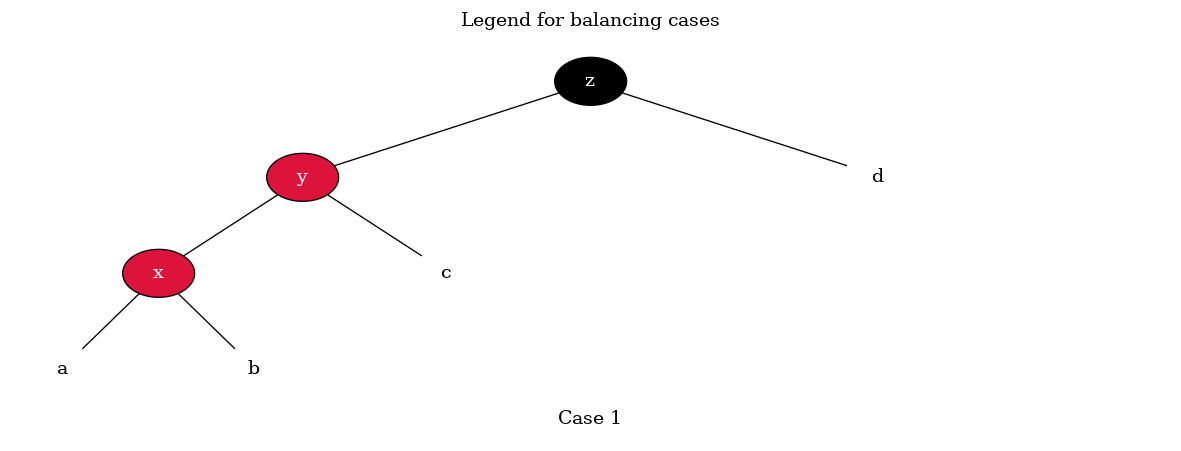

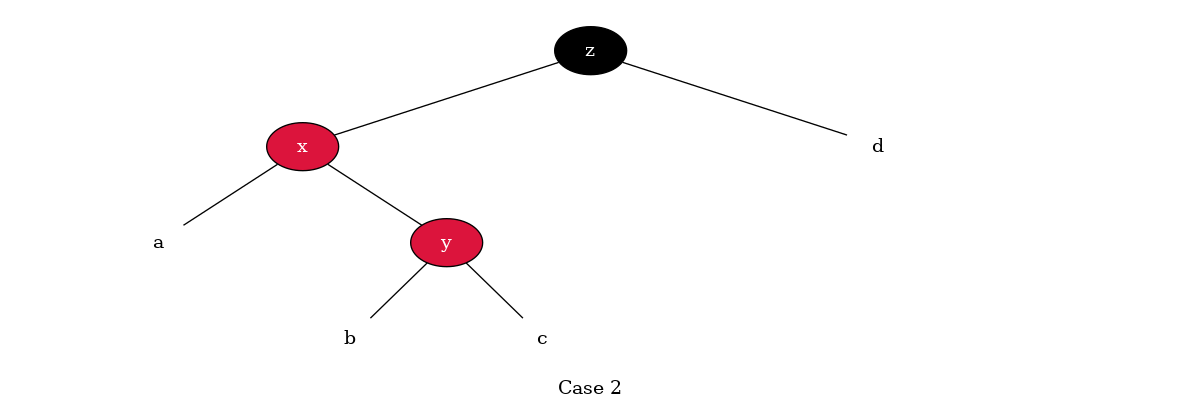

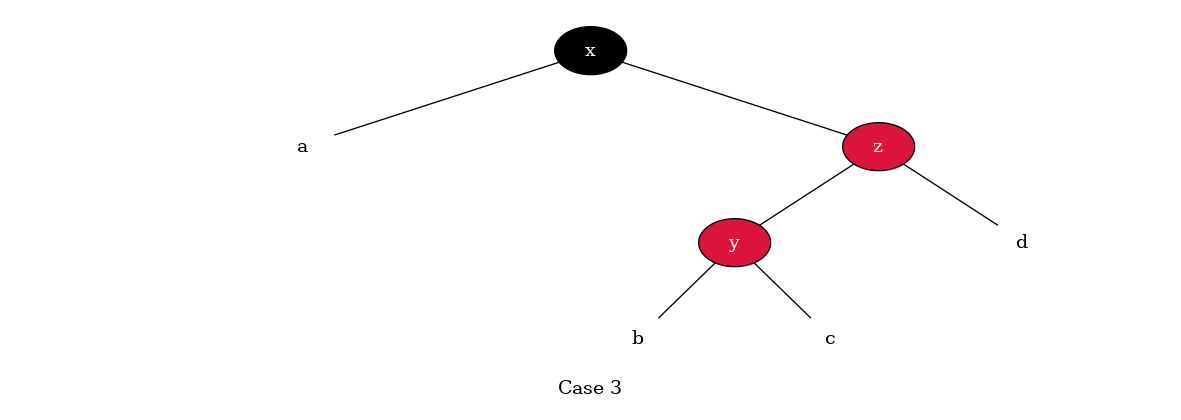

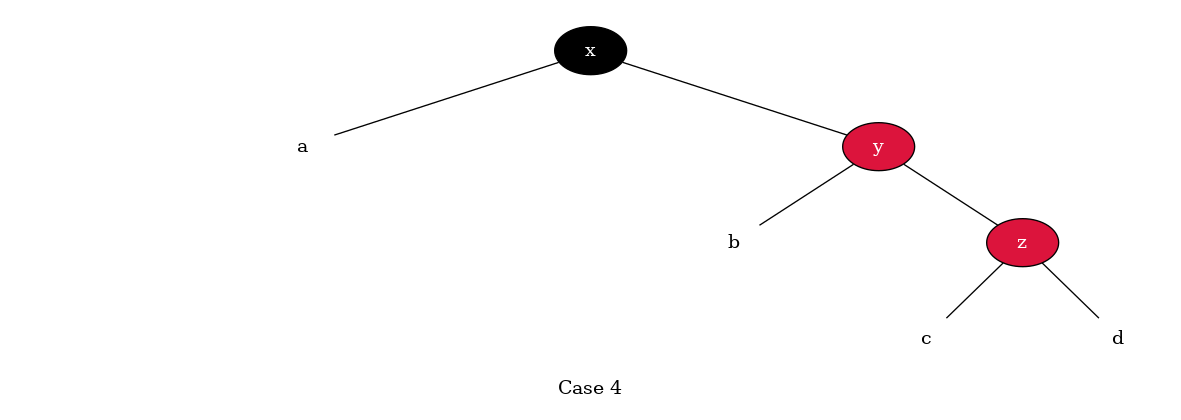

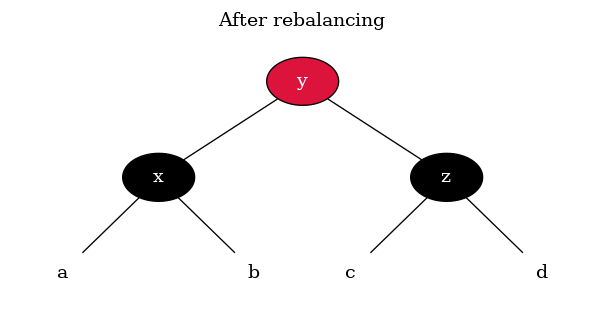

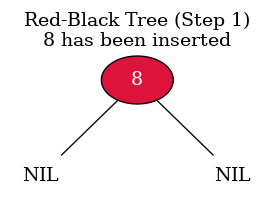

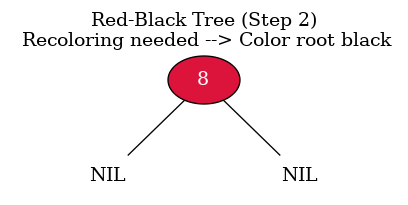

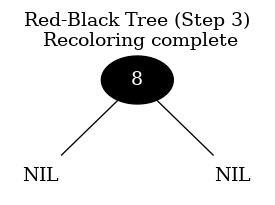

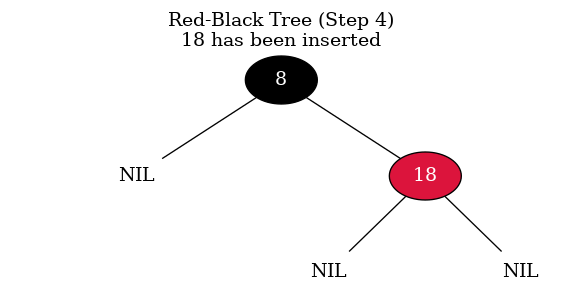

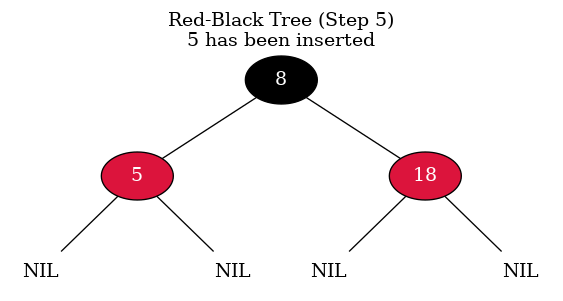

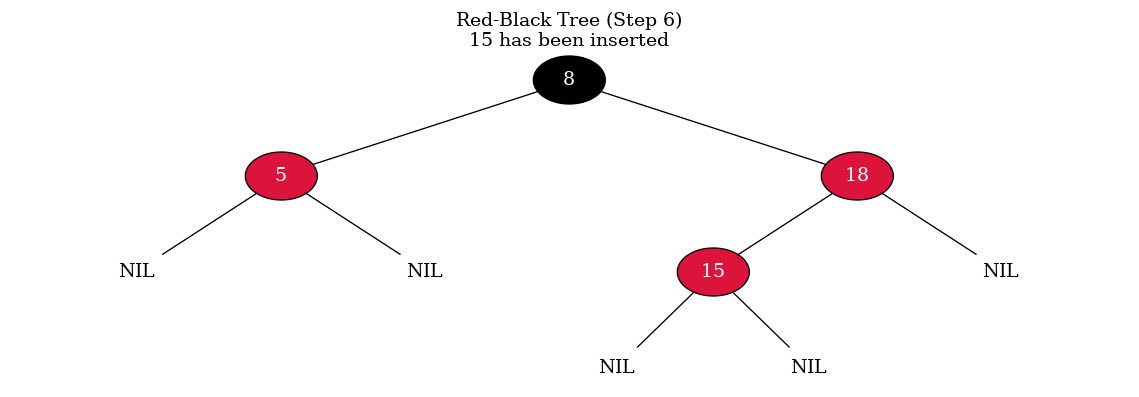

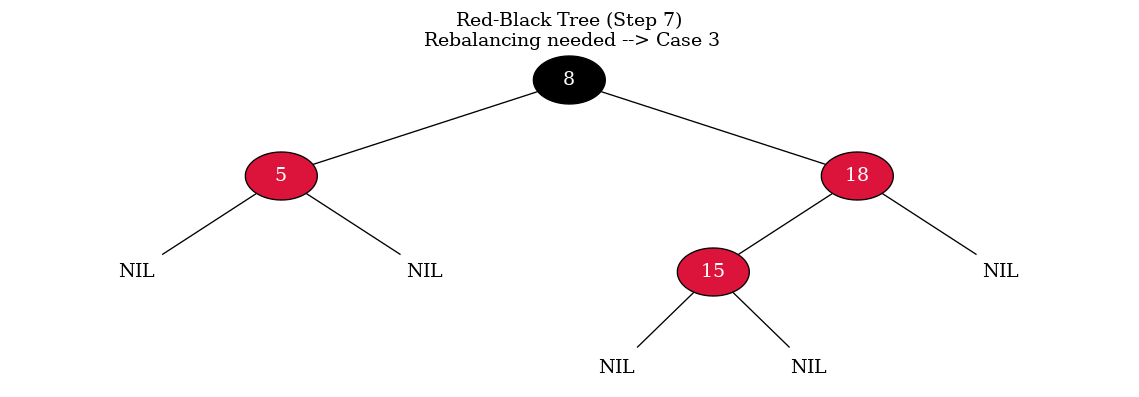

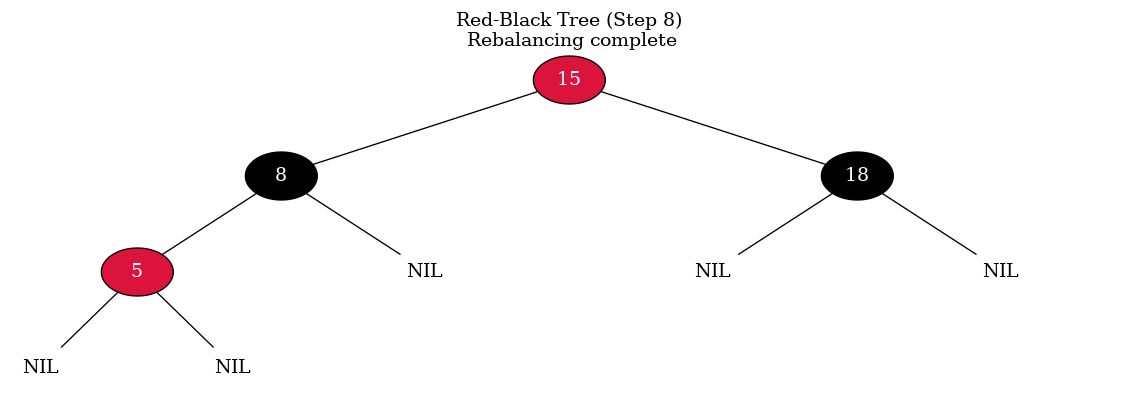

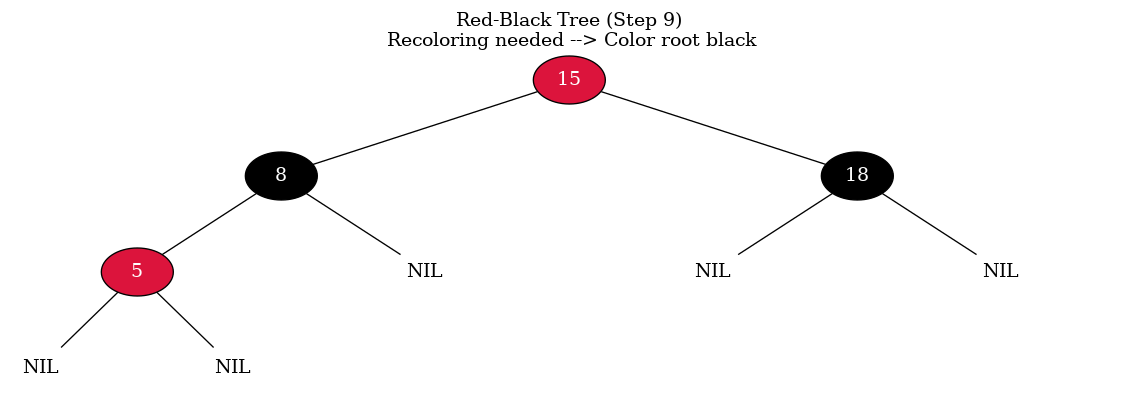

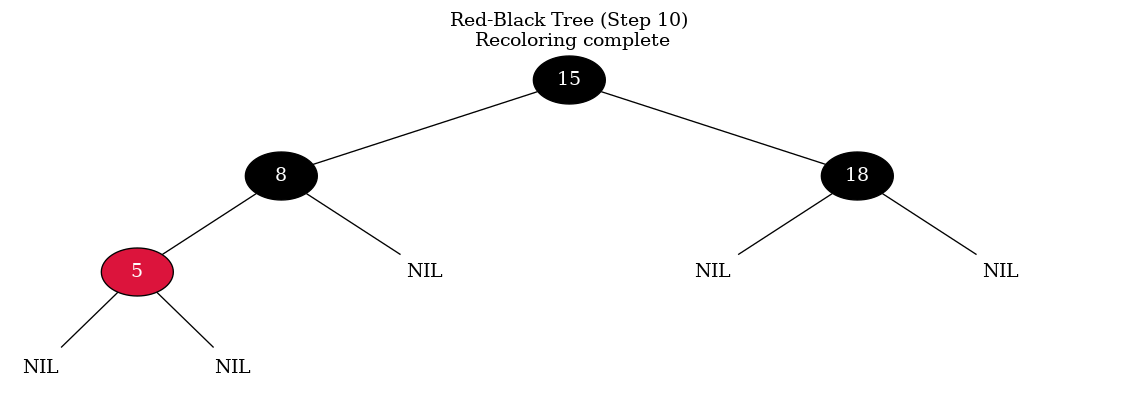

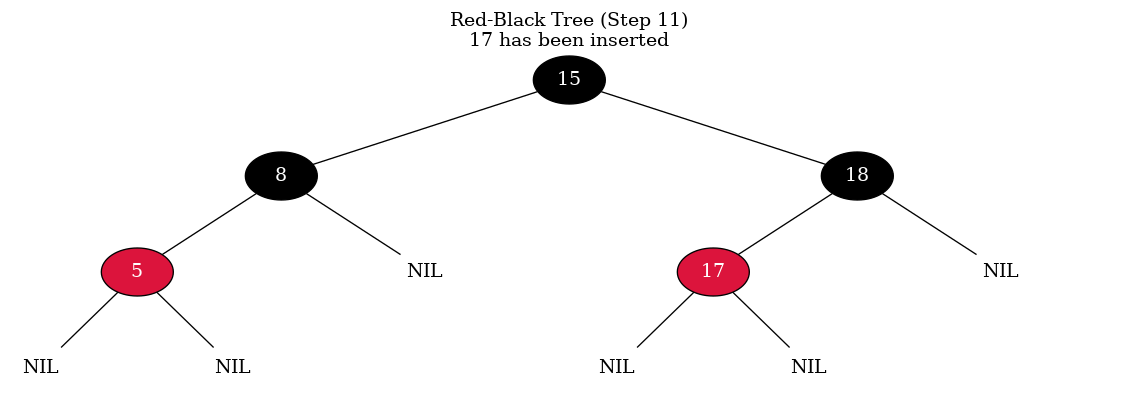

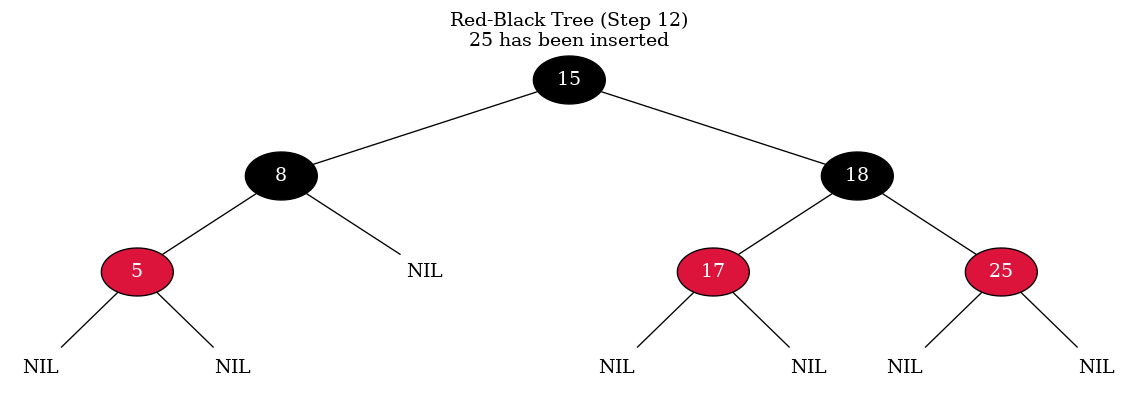

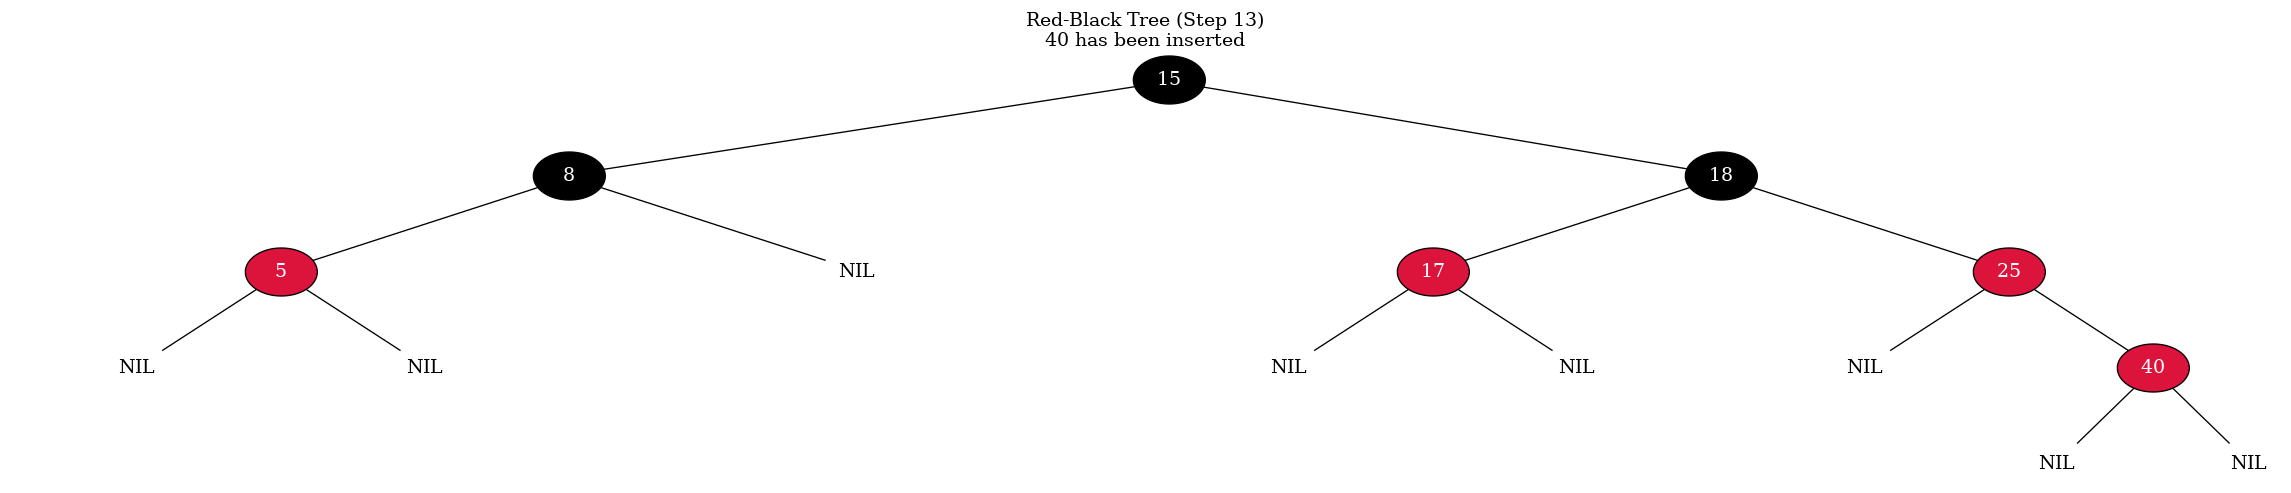

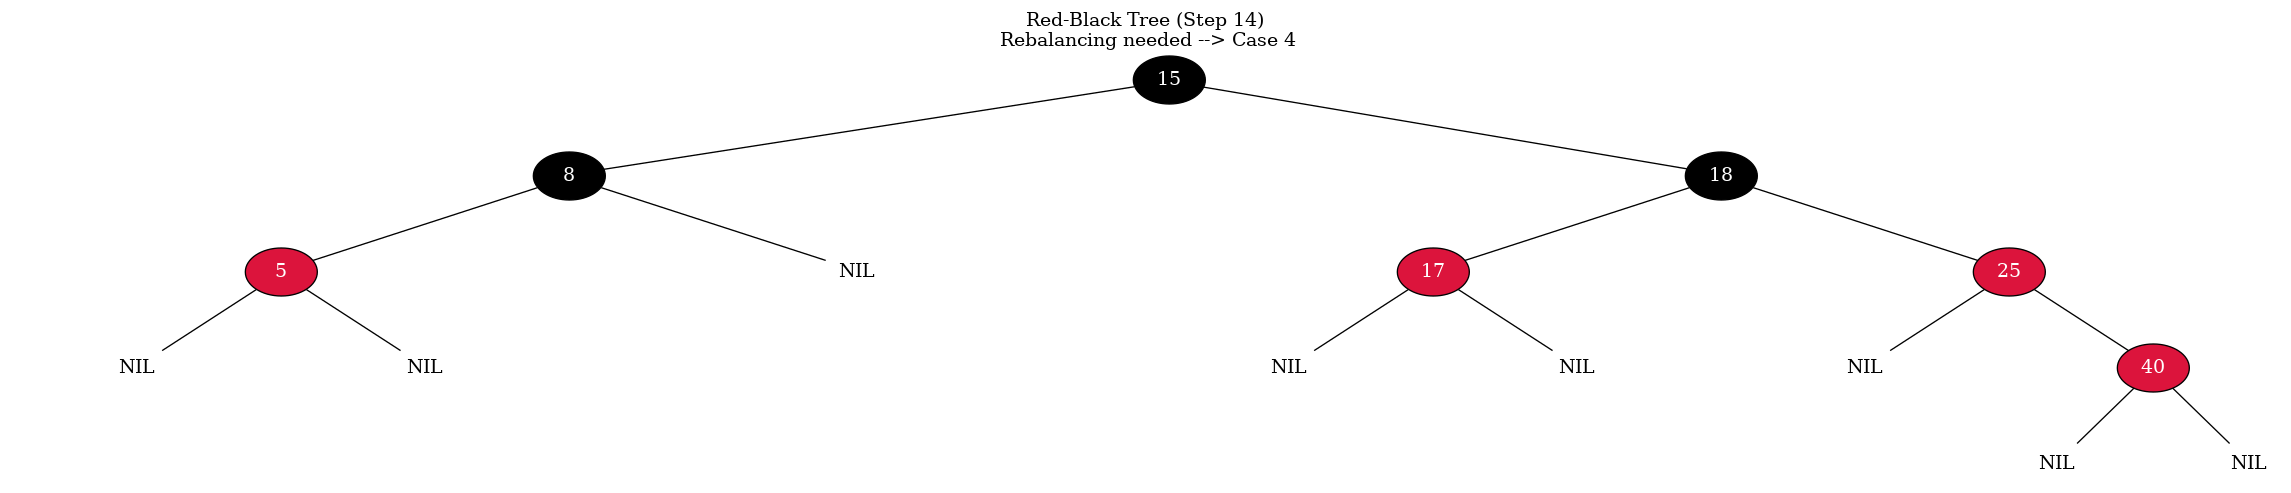

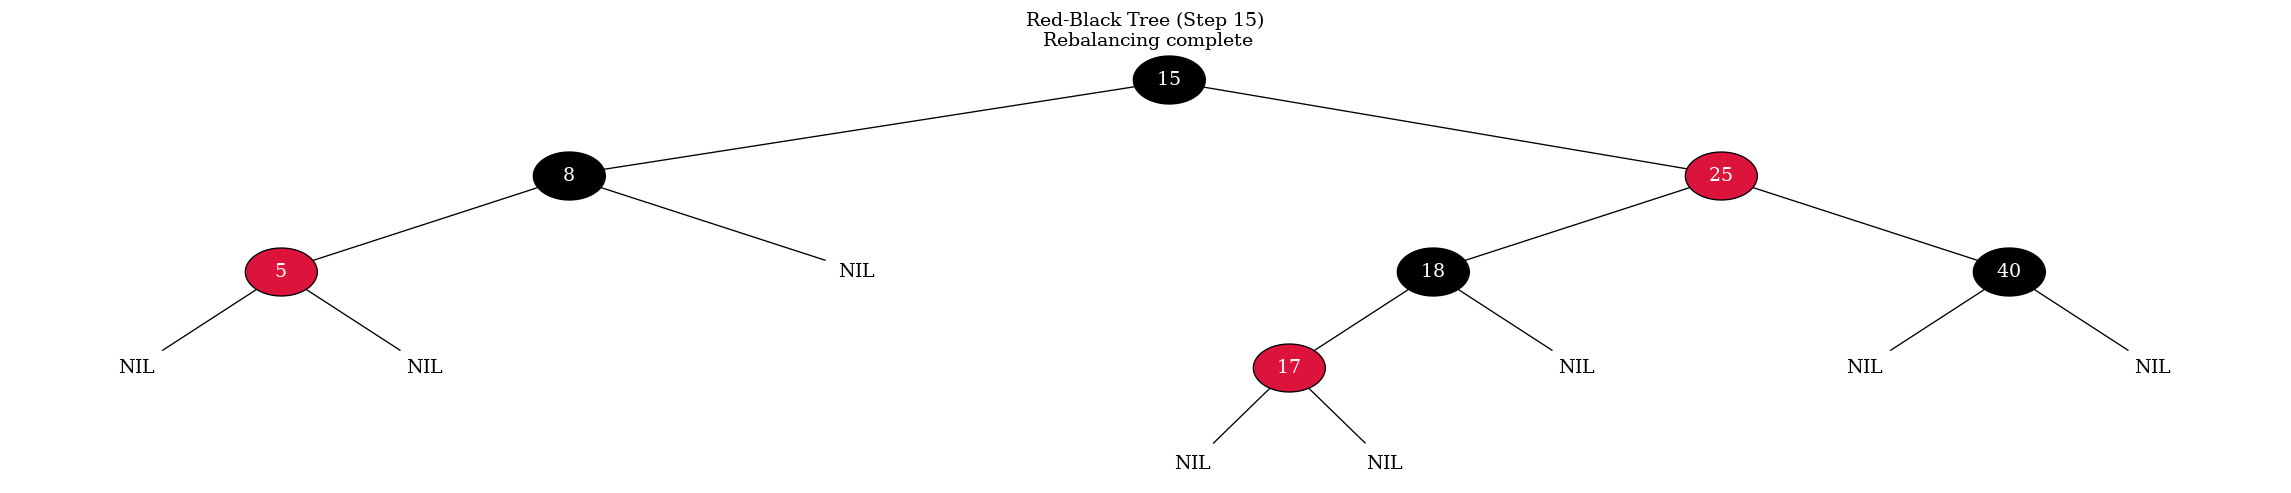

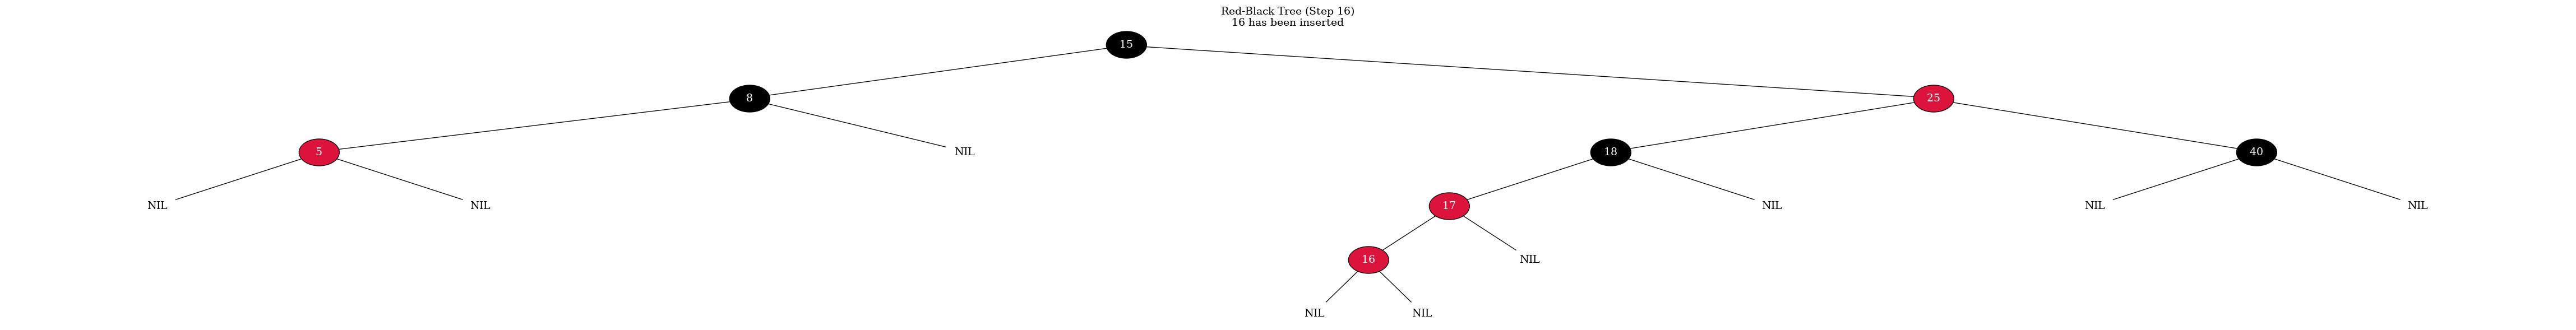

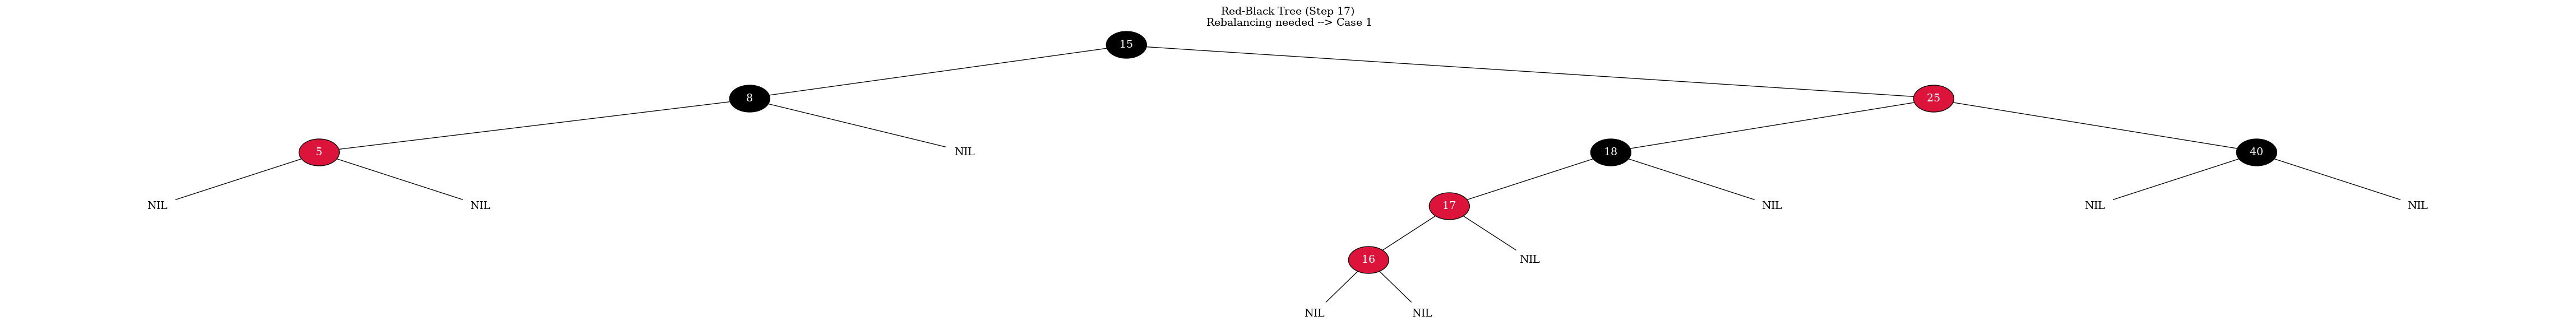

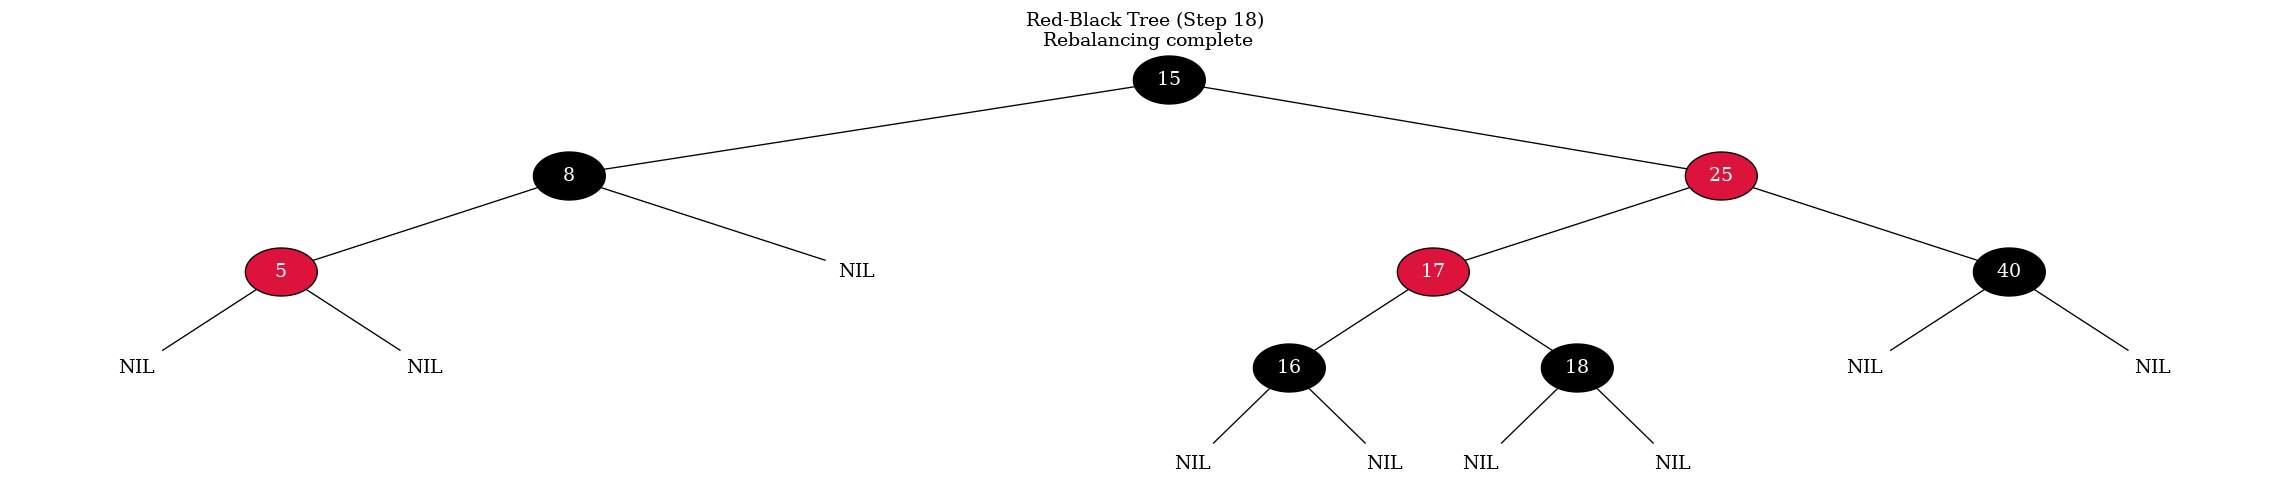

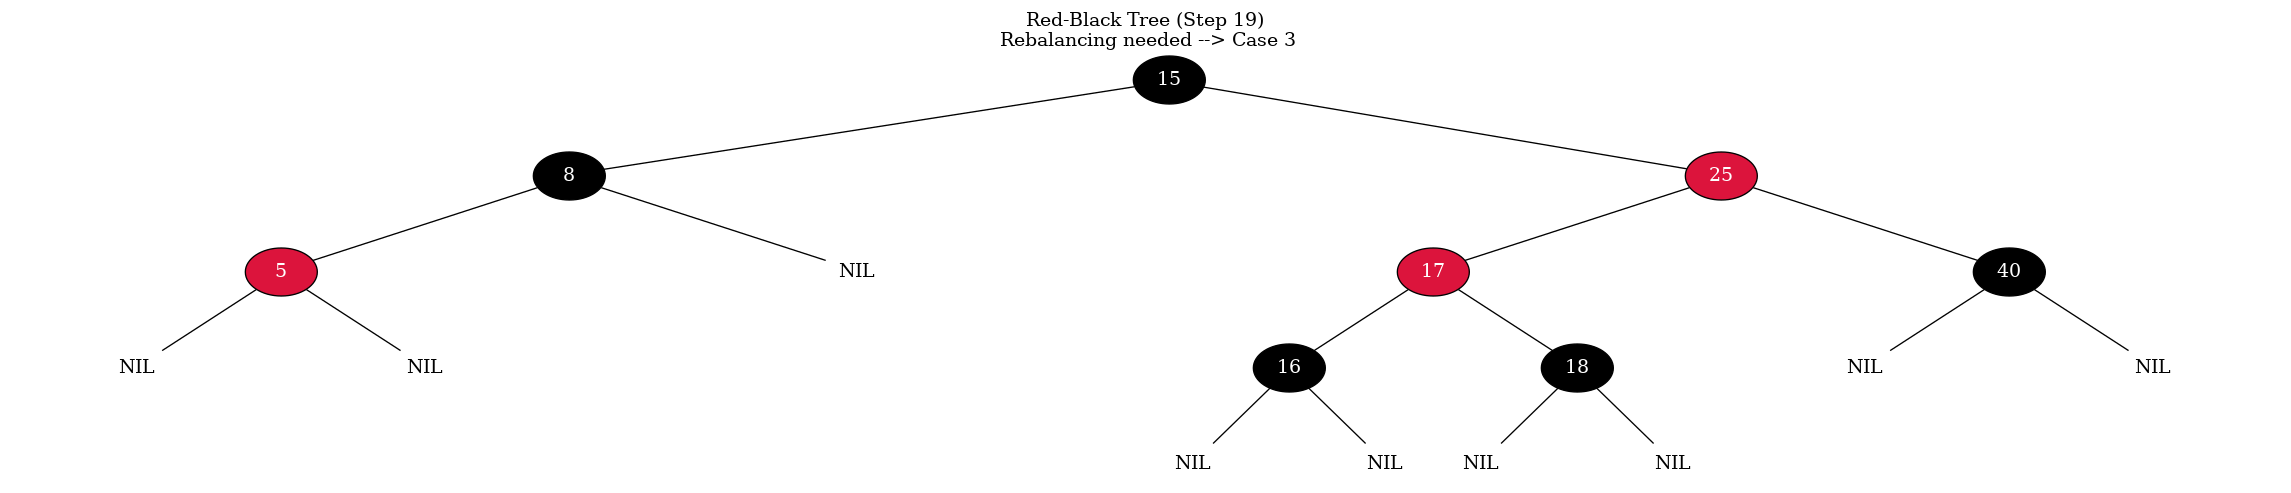

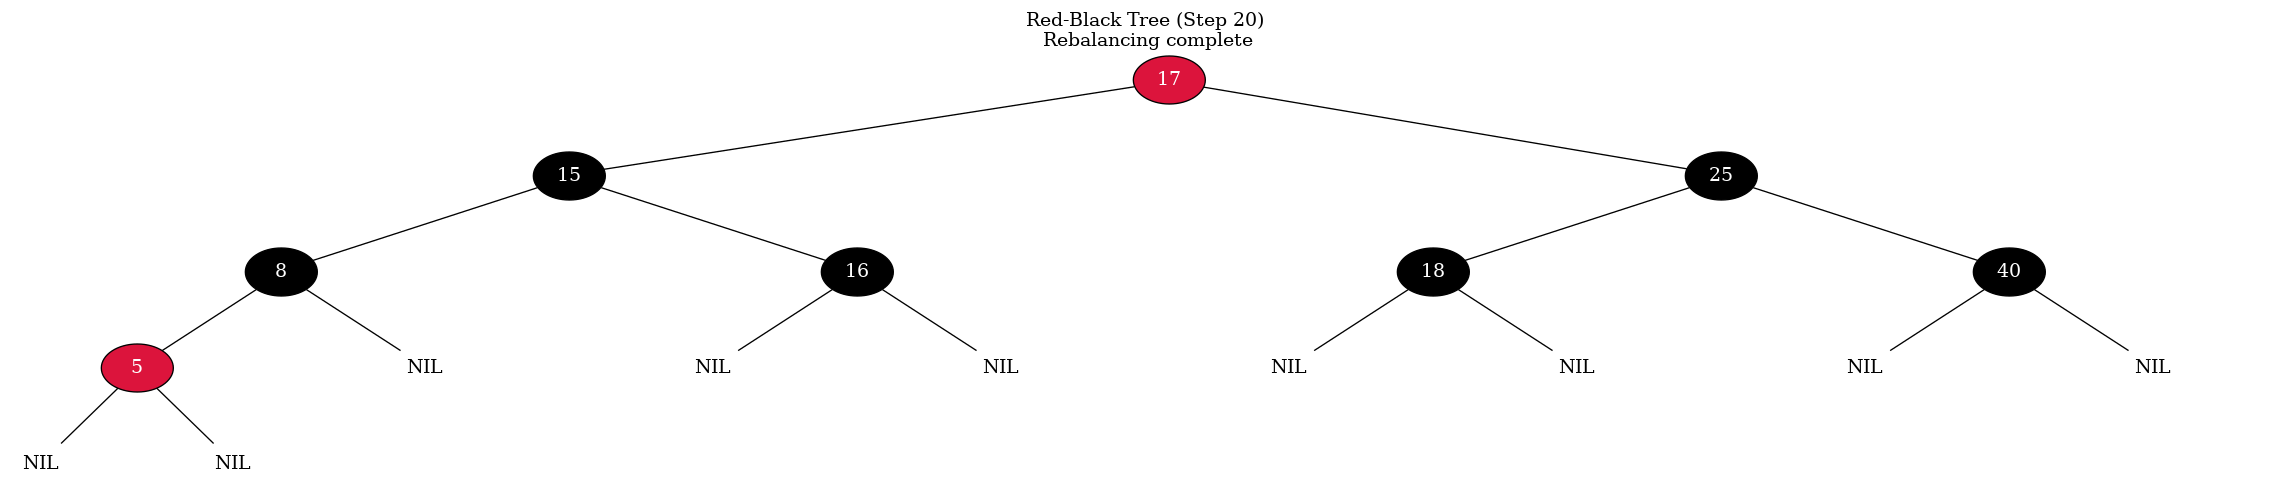

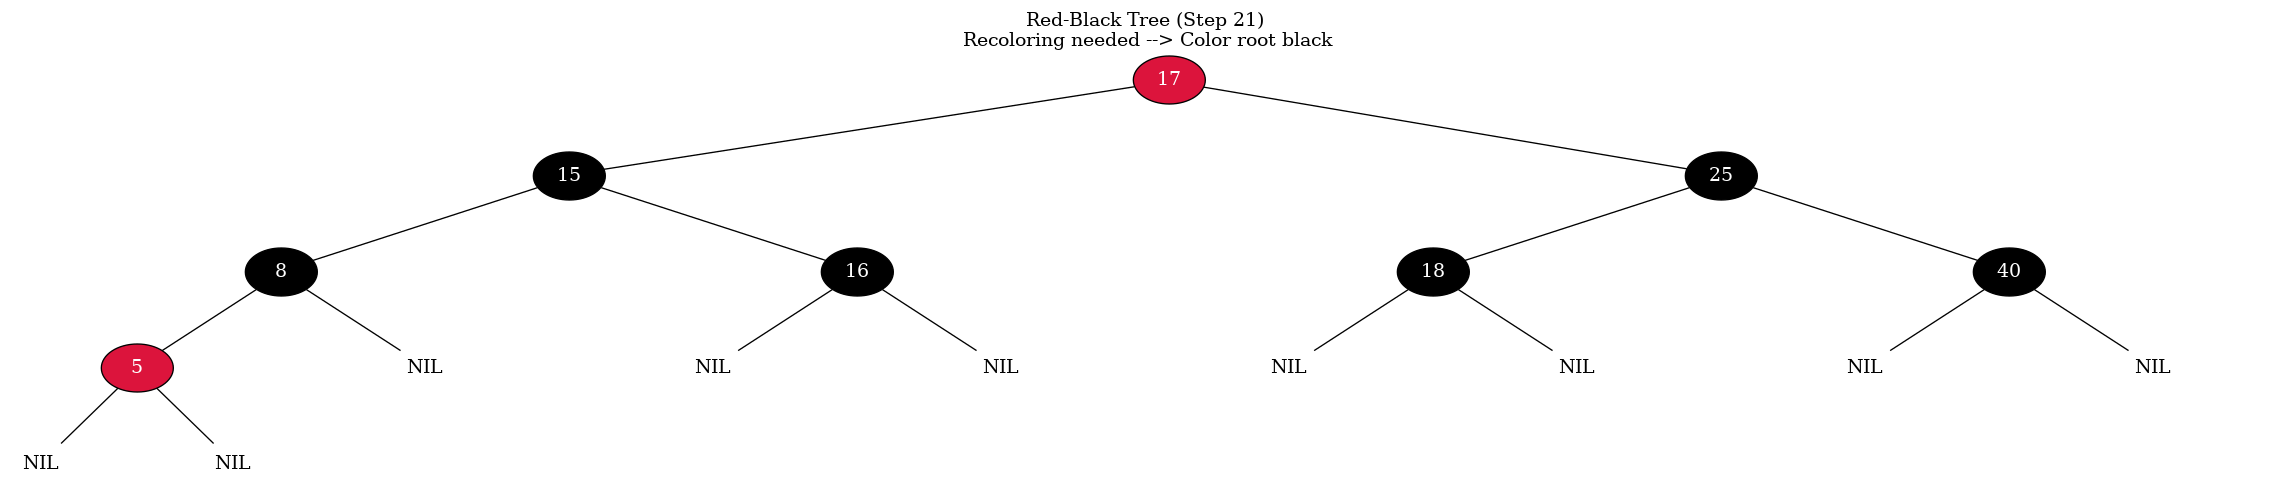

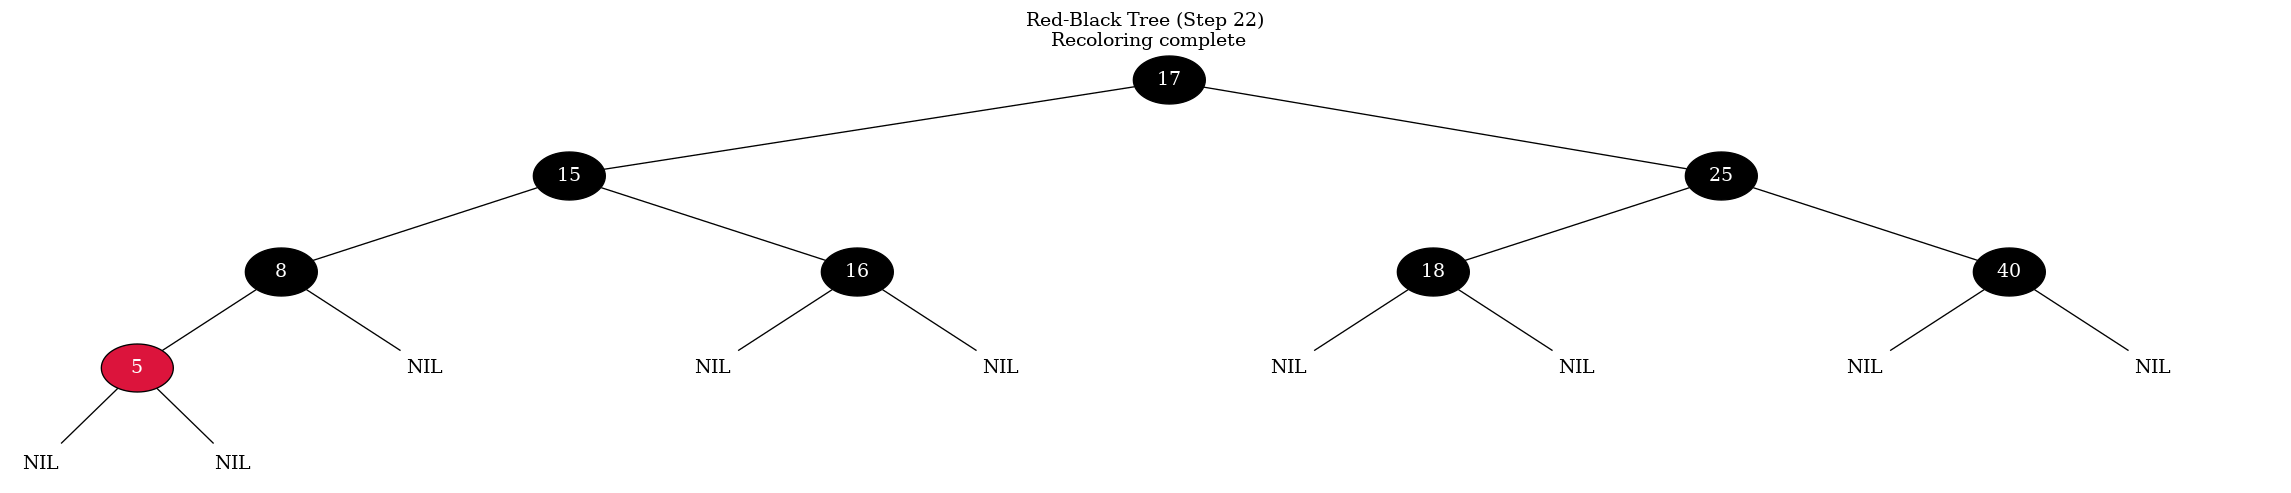

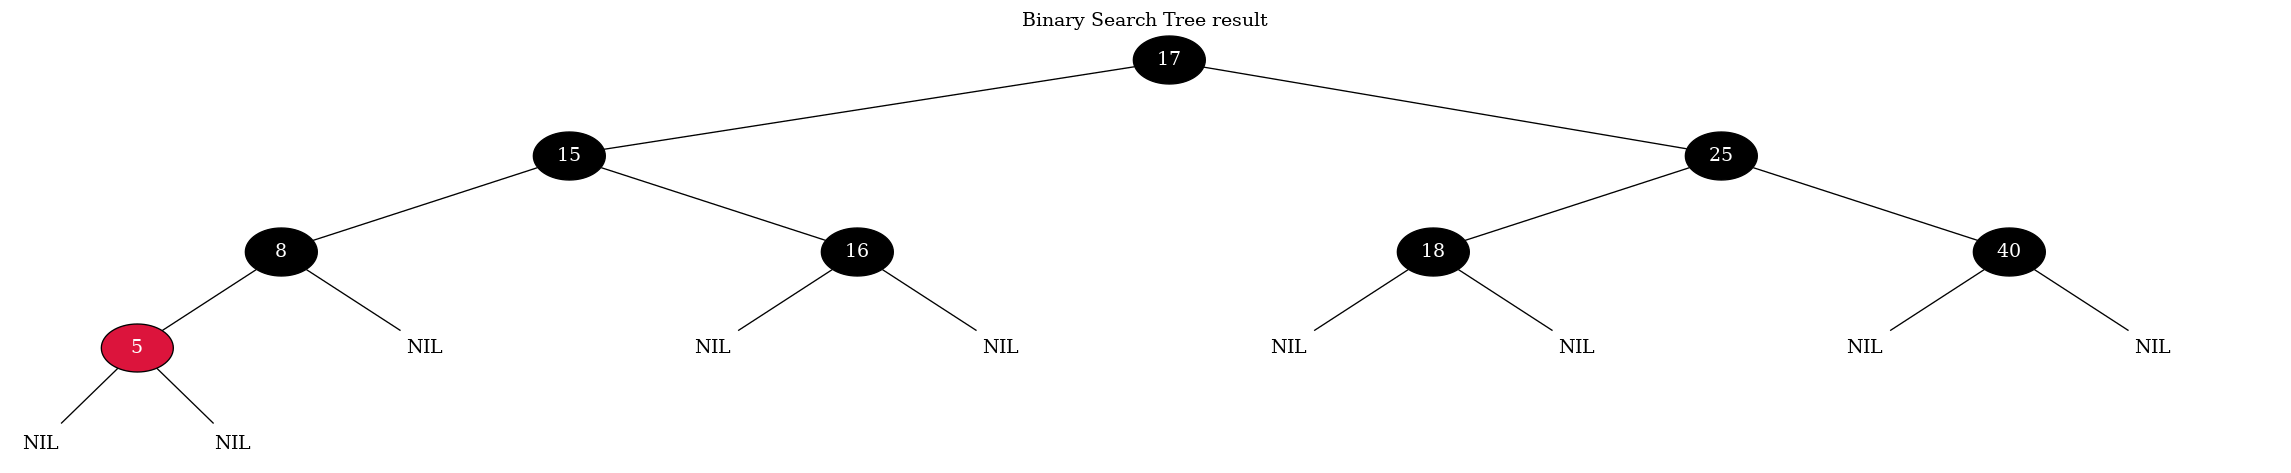

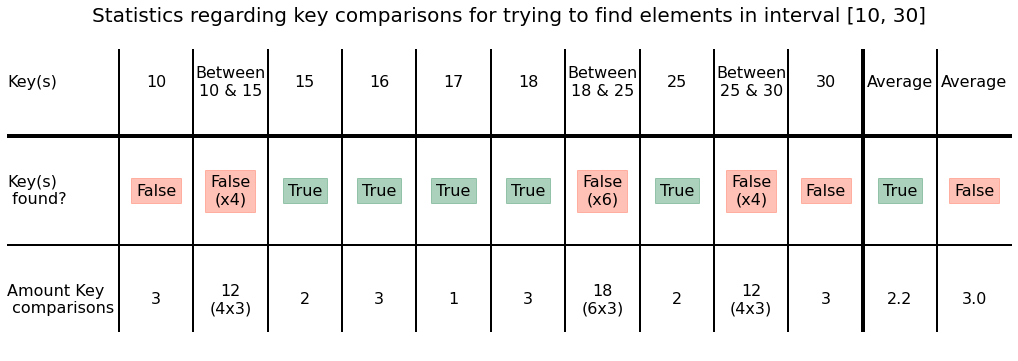

In [20]:
# Input the values you want to store in the tree
#input_values = [5, 62, 4, 35, 7, 5, 67, 9, 2, 16, 6, 1]
#input_values = [12, 16, 8, 3, 2, 15]
#input_values = [29, 42, 16, 33, 23, 25, 37, 50, 17, 51, 10, 30, 14, 45, 7]
#input_values = [2, 8, 19, 20, 35, 51, 55, 60, 79]
#input_values = [8, 18, 5, 15, 17, 25, 40, 80]
input_values = [8, 18, 5, 15, 17, 25, 40, 16]

# Input the minimum and maximum value which you want to search in the tree.
# This example would (try to) search every value from 10 to 30 and output statistics
search_interval=[10, 30]

# Set this to "True" if you want to see the insertions and balancing step by step
# Setting it to false only shows what the tree looks like when it is done
DISPLAY_STEP_BY_STEP = True

# Set show_case_legend to "True" if you want to have the 4 cases of rebalancing to be printed (the four cases of the AlgDat script)
show_output(input_values, search_interval, show_case_legend=True)

## Yet another example

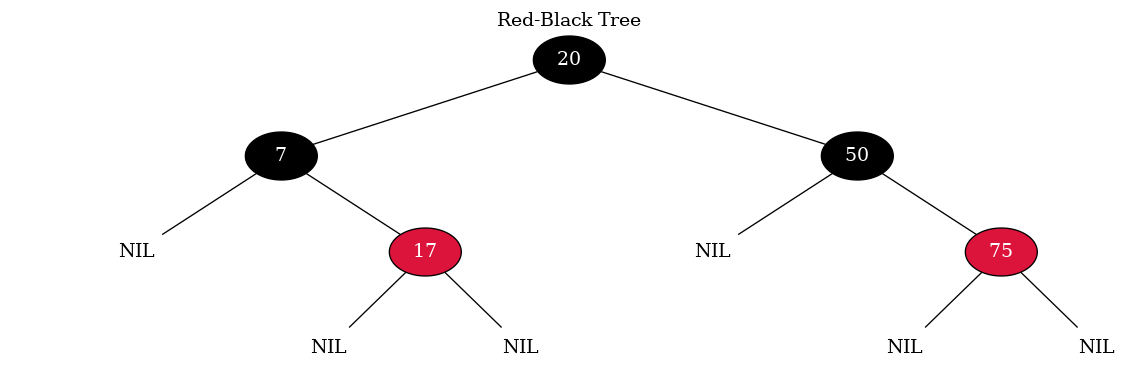

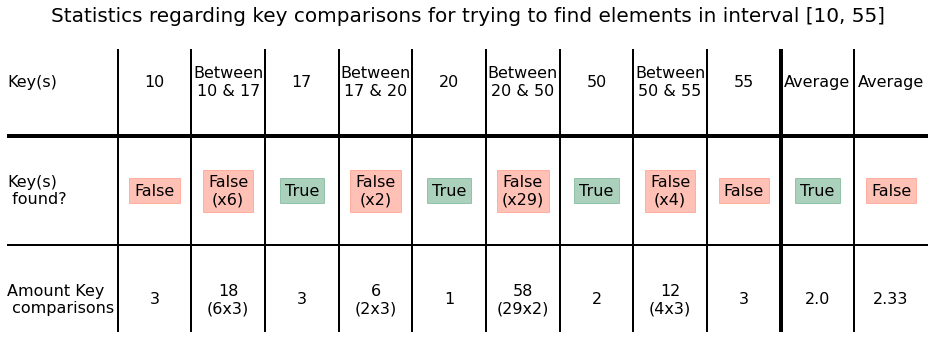

In [21]:
input_values = [50, 7, 20, 17, 75]

search_interval=[10, 55]

DISPLAY_STEP_BY_STEP = False
show_output(input_values, search_interval, show_case_legend=False)

## Randomly generated tree

The randomly generated list of size 6 :
 [25, 35, 74, 51, 10, 12] 
is turned into the following Red-Black Tree:


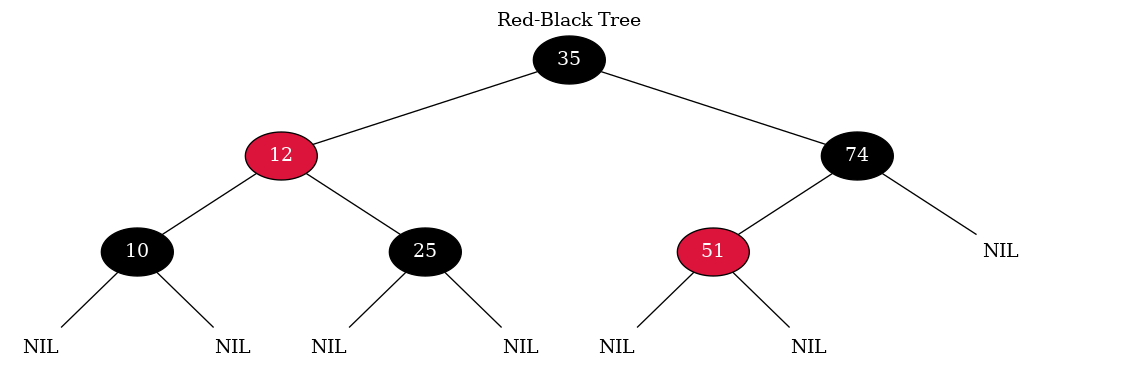

In [22]:
# Adjust how many values the randomly generated tree is supposed to have
amount_of_values = 6
min_max = [1, 100] # The minimum possible navlue and maximum possible value
random_input = generate_random_list(amount_of_values, min_max)

DISPLAY_STEP_BY_STEP = False
if random_input != None:
    print("The randomly generated list of size", amount_of_values, ":\n", random_input, "\nis turned into the following Red-Black Tree:")
    show_output(random_input, search_interval=[], show_case_legend=False)

## Your tests go here...

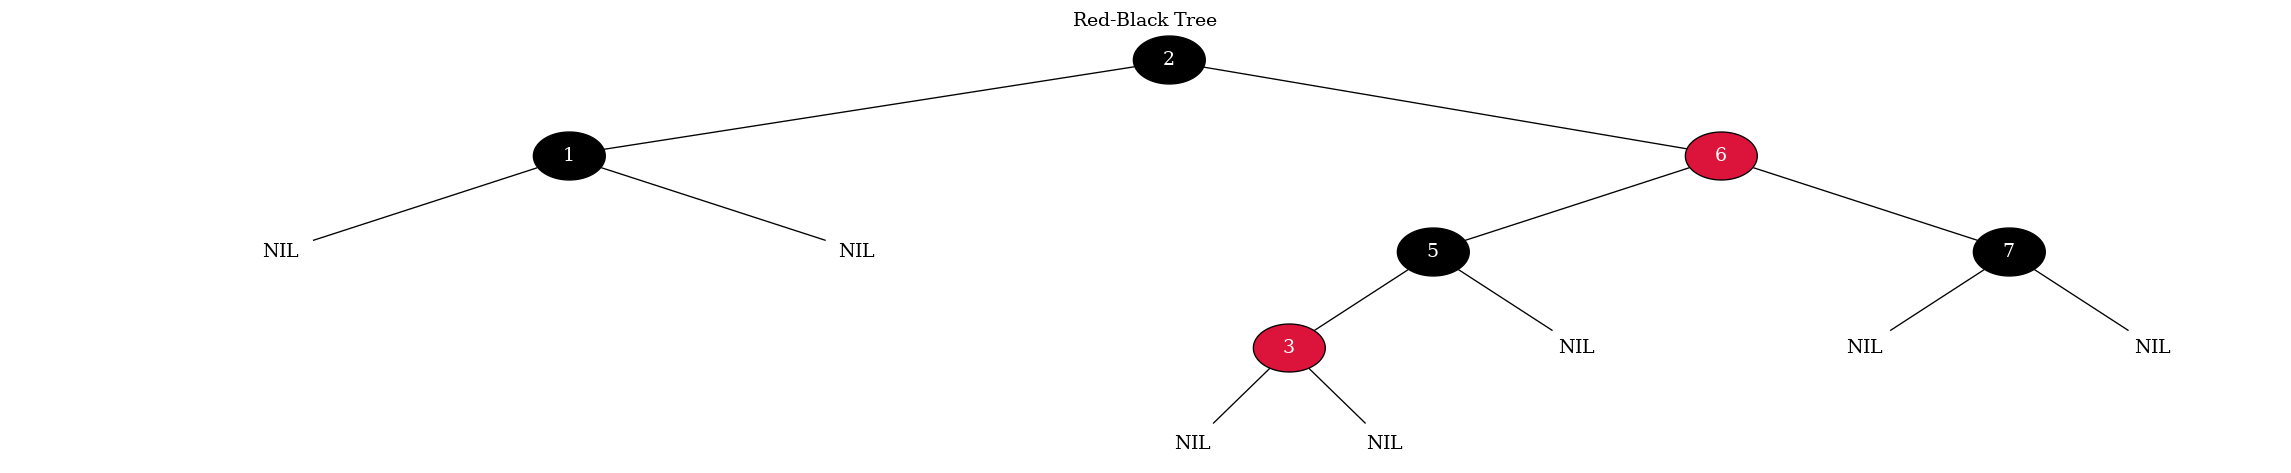

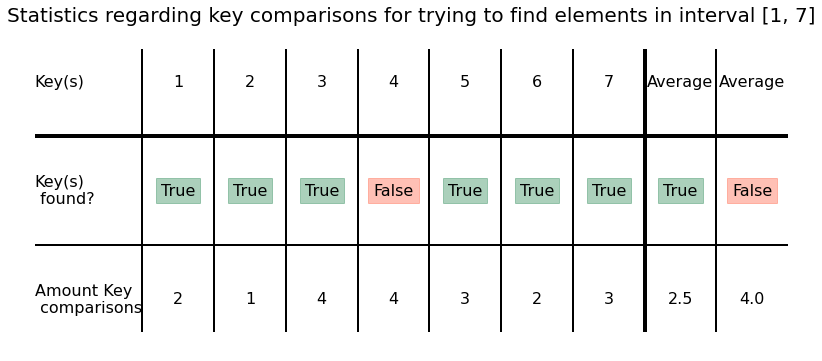

In [23]:
user_input = [5, 1, 2, 6, 7, 3]

search_interval = [1, 7]

DISPLAY_STEP_BY_STEP = False
show_output(user_input, search_interval, show_case_legend=False)